# Detect Diabetes Persons

## Import libraries and Read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

In [2]:
data=pd.read_csv("diabetes.csv")
df=data.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isnull().sum() # NO null values

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.duplicated().sum() # NO duplicated data

0

## Data Preprocessing and EDA

In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
x=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

y=['Outcome']

#### Handle Outlayers

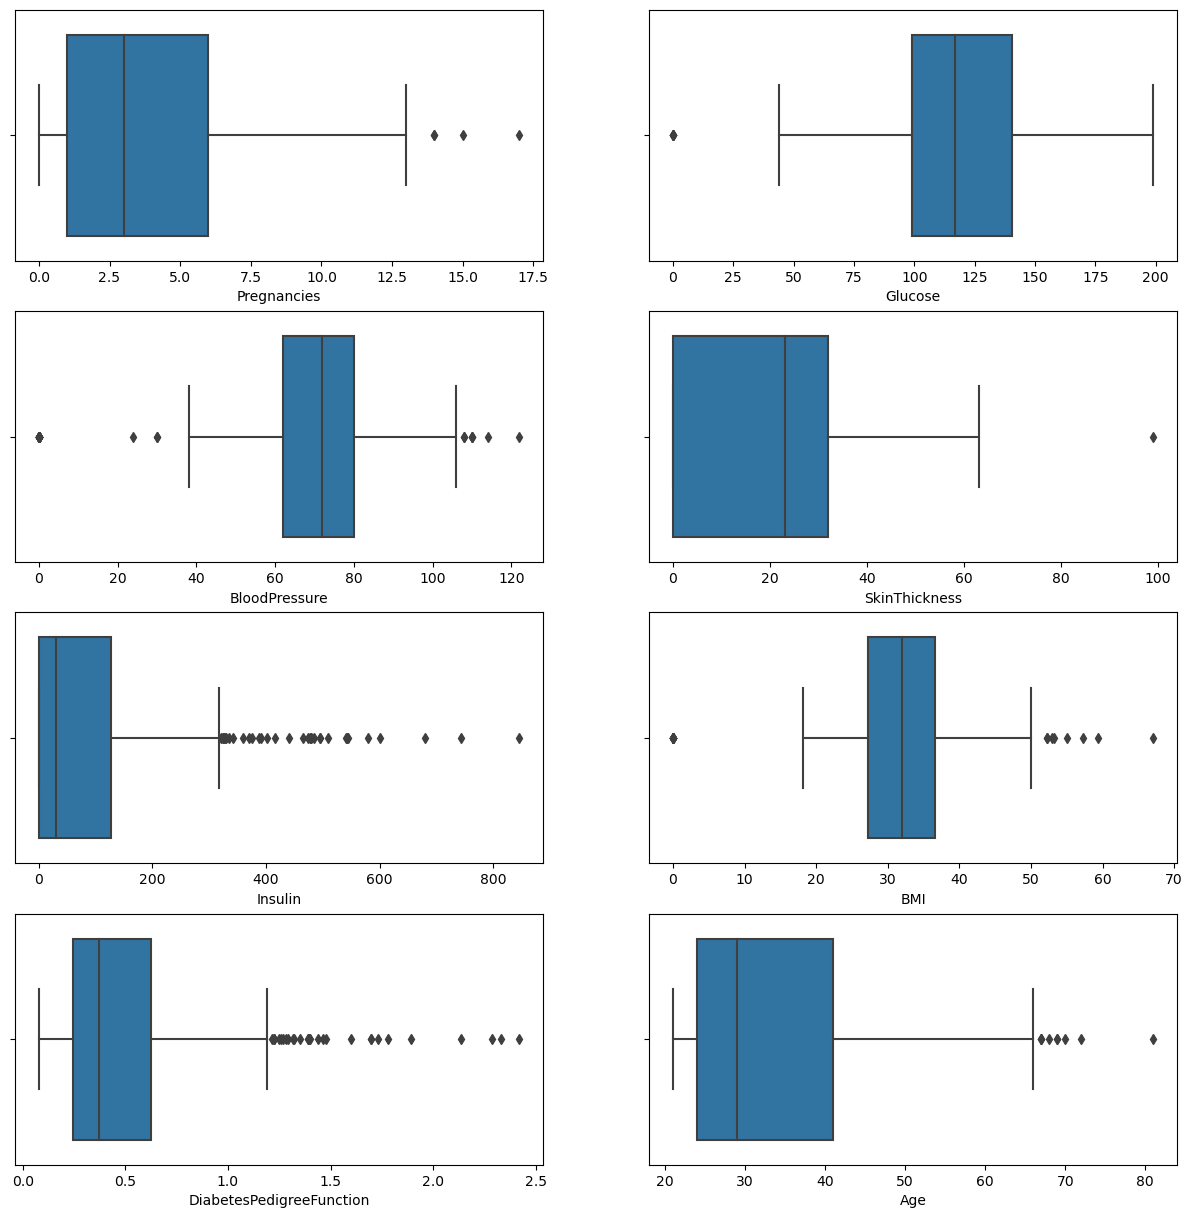

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  
    
for i, col in enumerate(x):
    ax = axes[i // 2, i % 2]  
    sns.boxplot(data=df, x=col, ax=ax)

In [9]:
def handle_outliers(df, columns):
    for column in columns:
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with the boundary values
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df


df = handle_outliers(df ,x )

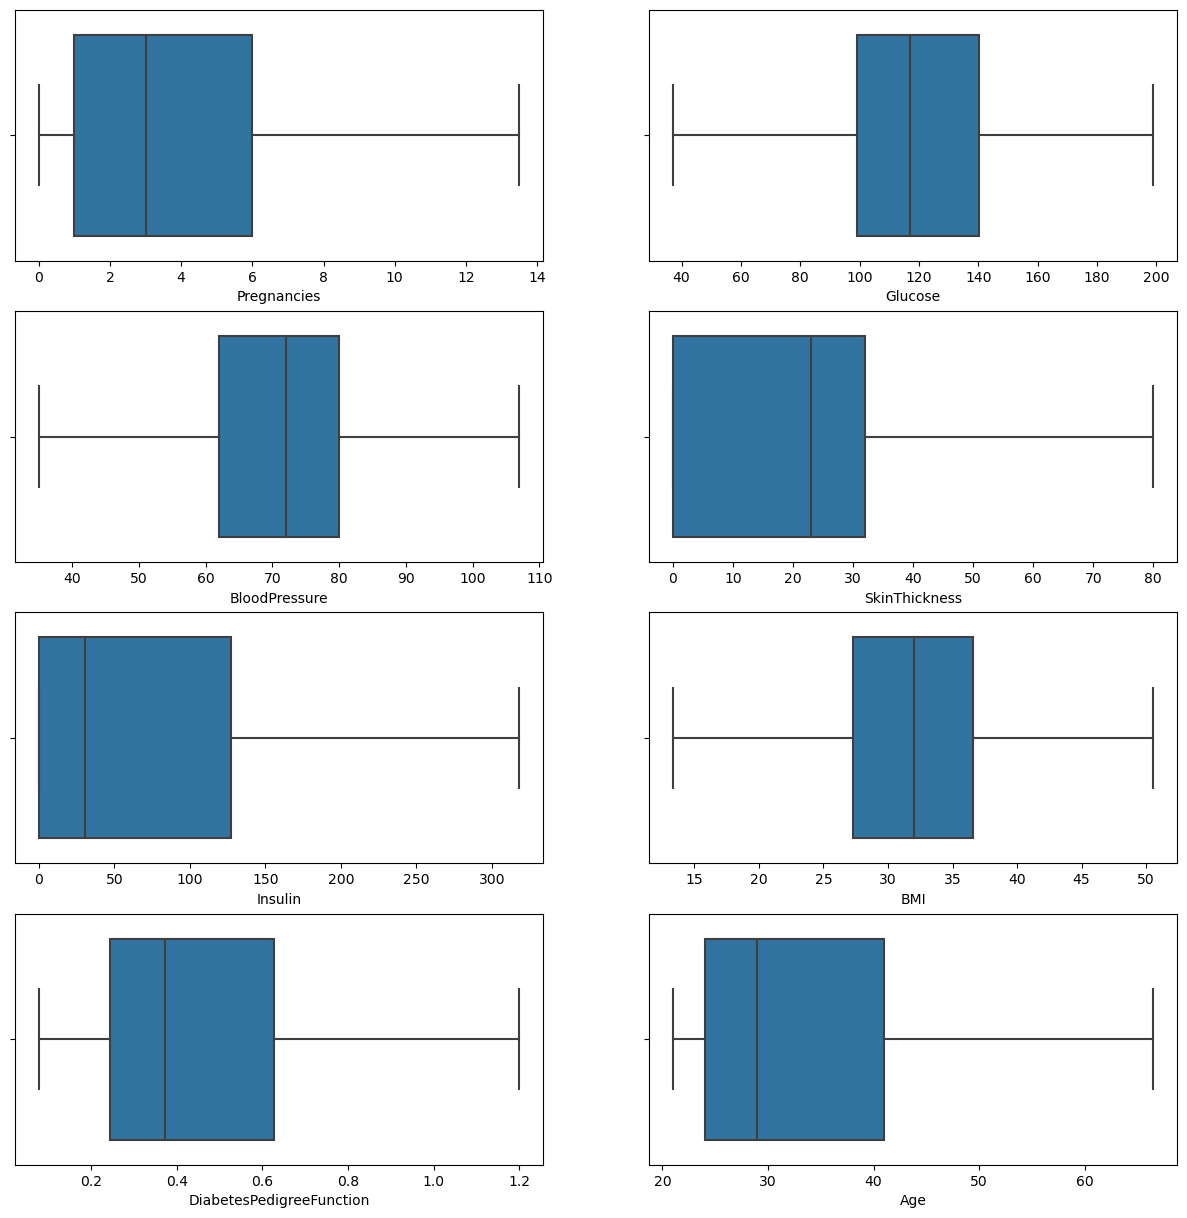

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))  
    
for i, col in enumerate(x):
    ax = axes[i // 2, i % 2]  
    sns.boxplot(data=df, x=col, ax=ax)

#### Split Data

In [11]:
y=df.iloc[:,-1]
x=df.iloc[:,:-1]

print (f"shape of x:{x.shape}")
print (f"shape of y:{y.shape}")

shape of x:(768, 8)
shape of y:(768,)


#### Handling imblanced 

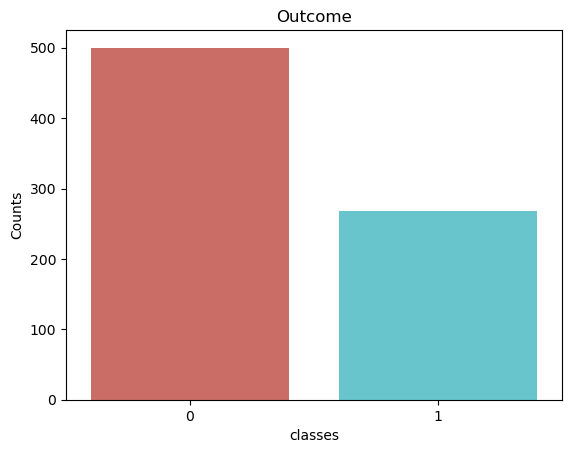

In [12]:
sns.countplot(x=y, data=x, palette='hls')
plt.ylabel('Counts') 
plt.xlabel('classes')
plt.title('Outcome')
plt.show()

<Axes: >

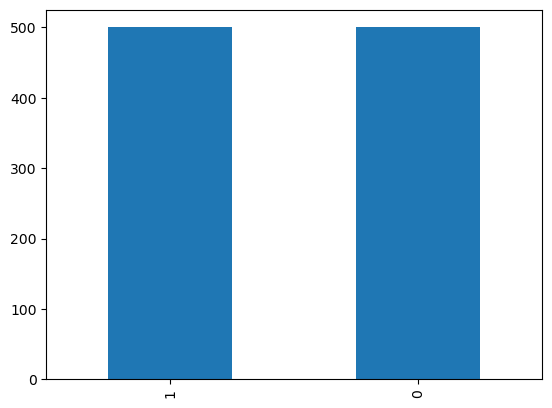

In [13]:
from imblearn.over_sampling import SMOTE 

oversampler = SMOTE(random_state=42) # RandomOversampling 
x_resampled, y_resampled = oversampler.fit_resample(x, y)
y_resampled.value_counts().plot(kind='bar')

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_resampled, y_resampled,test_size=0.25,random_state=42)

print (f"shape of x_train:{x_train.shape}")
print (f"shape of y_train:{y_train.shape}")
print (f"shape of x_test:{x_test.shape}")
print (f"shape of y_test:{y_test.shape}")

shape of x_train:(750, 8)
shape of y_train:(750,)
shape of x_test:(250, 8)
shape of y_test:(250,)


#### Data Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

#### One Hot Encoding For Output

In [16]:
onehot=pd.get_dummies(y_train)
target_labels=onehot.columns
y_train=np.array(onehot)

onehot=pd.get_dummies(y_test)
target_labels=onehot.columns
y_test=np.array(onehot)

## Create Model

In [17]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=10)

n_cols=x_train.shape[1]

model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(n_cols,)))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(2,activation='softmax'))

C:\Users\ELFEKY\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit (x_train,y_train,validation_split=0.3,epochs=100,callbacks=[early_stopping_monitor])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5431 - loss: 0.6877 - val_accuracy: 0.6444 - val_loss: 0.6452
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6931 - loss: 0.6284 - val_accuracy: 0.6578 - val_loss: 0.6274
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6344 - loss: 0.6254 - val_accuracy: 0.7467 - val_loss: 0.5265
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7210 - loss: 0.5434 - val_accuracy: 0.7289 - val_loss: 0.5479
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7892 - loss: 0.4743 - val_accuracy: 0.7778 - val_loss: 0.4632
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7960 - loss: 0.4666 - val_accuracy: 0.7822 - val_loss: 0.4630
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7925 - loss: 0.4689 - val_accuracy: 0.7644 - val_loss: 0.4853
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7989 - loss: 0.4343 - val_accuracy: 0.7600 - 

In [19]:
val_loss,val_acc=model.evaluate(x_test,y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7154 - loss: 0.6054 


In [33]:
val_acc

0.7319999933242798

In [34]:
model.save('diabetes_model.h5')

In [35]:
from keras.models import load_model
model=load_model('diabetes_model.h5')

In [36]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 512)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,732 (702.08 KB)

 Trainable params: 179,730 (702.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)